In [1]:
import ssm
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Conspecific_Tracking_ta_edit_117 as cs
from scipy import interpolate 
from beating import rotation,tail_spline,plot_tail
from hmmlearn import hmm

# data input

In [2]:
# read data for 5 fish
path = "/Users/miaoyuqi/研究/Statistical analyses of Siamese fighting fish aggressive behavior/DSI-Students/Yuqi_scripts/IM1_IM2Fish1_AN.h5"
f = pd.HDFStore(path,'r')
data_top2 = f.get('df_with_missing')
data_top2.columns = data_top2.columns.droplevel()
# data_top = cs.auto_scoring_tracefilter(data_top)
# data_top2 = data_top[data_top.isnull()["F_spine1"]["x"]== False].fillna(method = "ffill")

## without thinking likelihood

In [3]:
def auto_scoring_tracefilter_spine1(data,p0=20,p1=50):
    # Yuyang's method
    #remove the not close to origin check(i don't know the meaning of it currently)
    #Add a check for spine and tail detection precision check, the logic goes as follow:
    #1.Since it looks like the spine1 prediction is quite accurate, I didn't check that
    #2.For other points except tail tip, I compare the distance of the point with the next point and the previous point, 
    # if they are both large, I change that point to nan
    # for the tailtip, I compared it to the previous 2 points and the rest is almost the same.
    mydata = data.copy()
    boi = ['A_head','B_rightoperculum','E_leftoperculum',"F_spine1","G_spine2","H_spine3","I_spine4","J_spine5","K_spine6","L_spine7",'C_tailbase']
    for b in boi:
        for j in ['x','y']:
            xdifference = abs(mydata[b][j].diff())
            xdiff_check = xdifference > p0     
            mydata[b][j][xdiff_check] = np.nan
    spine_column=["F_spine1","G_spine2","H_spine3","I_spine4","J_spine5","K_spine6","L_spine7",'D_tailtip','C_tailbase']
    for i,c in enumerate(spine_column):
        if (i>1 and i<(len(spine_column)-1)):
            dist1=np.sqrt(np.square(data[spine_column[i-1]]['x']-data[c]['x'])+np.square(data[spine_column[i-1]]['y']-data[c]['y']))
            dist2=np.sqrt(np.square(data[spine_column[i+1]]['x']-data[c]['x'])+np.square(data[spine_column[i+1]]['y']-data[c]['y']))
            dist_check=np.logical_and(dist1>p1,dist2>p1)
            mydata[c]["x"][dist_check] = np.nan
            mydata[c]["y"][dist_check] = np.nan
        if i==(len(spine_column)-1):
            dist1=np.sqrt(np.square(data[spine_column[i-1]]['x']-data[c]['x'])+np.square(data[spine_column[i-1]]['y']-data[c]['y']))
            dist2=np.sqrt(np.square(data[spine_column[i-2]]['x']-data[c]['x'])+np.square(data[spine_column[i-2]]['y']-data[c]['y']))
            dist_check=np.logical_and(dist1>p1,dist2>p1)
            mydata[c]["x"][dist_check] = np.nan
            mydata[c]["y"][dist_check] = np.nan
    return mydata

In [4]:
spine_column=["F_spine1","G_spine2","H_spine3","I_spine4","J_spine5","K_spine6","L_spine7",'D_tailtip','C_tailbase']
for i,c in enumerate(spine_column):
    print(i,c)

0 F_spine1
1 G_spine2
2 H_spine3
3 I_spine4
4 J_spine5
5 K_spine6
6 L_spine7
7 D_tailtip
8 C_tailbase


In [5]:
filter1 = auto_scoring_tracefilter_spine1(data_top2, p1 = 20)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
def spine_point(data):
    x_index = [0, 15, 18, 21, 24, 27, 30, 33]
    y_index = [1, 16, 19, 22, 25, 28, 31, 34]
    x = data.iloc[:,x_index]
    y = data.iloc[:,y_index]
    spline_point = np.column_stack([x,y])
    spline_point = spline_point.reshape((len(data),8,2), order = "F")

    return spline_point

In [7]:
def spine_10plot(data, range_censor):
    j = 0
    fig,ax = plt.subplots(2,5,figsize=(20, 10))
    maintain = list()
    for i in range_censor:
        x = np.array(data[i])
        pts = np.delete(x,np.where(np.isnan(x))[0],axis=0)
        tck, u = interpolate.splprep(pts.T, u=None, s=0.0) 
        u_new = np.linspace(u.min(), u.max(), 1000)
        x_new, y_new = interpolate.splev(u_new, tck, der=0)
        ax[j//5,j%5].plot(pts[:,0], pts[:,1], 'ro')
        ax[j//5,j%5].plot(x_new, y_new, 'b--')
        ax[j//5,j%5].set_title(i)
        maintain.append(len(pts))
        j = j+1
    return maintain


# functions

## likelihood

In [8]:
## claire method: filtering extreme likelihood
def Combine_filter_CE (data, p0 = 20  , p1 = 5):
    '''
    
    This function filters  based on 1) jumps between frames, 2) the liklihood of the position, 3) the closeness of the points
    It does not filter based on any distance (Yuqi and Yuyang can perfect)
    
    returns a whole dataframe with NANs according to general and specific spine criterion
    '''
    mydata = data.copy()
    #boi = ['A_head','B_rightoperculum','E_leftoperculum',"F_spine1","G_spine2","H_spine3","I_spine4","J_spine5","K_spine6","L_spine7", 'D_tailtip','C_tailbase']
    boi = ['B_rightoperculum','E_leftoperculum',"I_spine4","J_spine5","K_spine6","L_spine7", 'D_tailtip','C_tailbase']
    # for the likelihood with .1 quantile more than 0.5, don't filter by likelihood
    for b in boi:
        for j in ['x','y']:
            xdifference = abs(mydata[b][j].diff())
            xdiff_check = xdifference > p0     
            mydata[b]["x"][xdiff_check] = np.nan
            mydata[b]["y"][xdiff_check] = np.nan
        threshold = mydata[b]['likelihood'].quantile(.1) ## only see the extrem tail?
        print(b +":"+str(threshold))
        lik_check = mydata[b]['likelihood'] < threshold ## likelihood is the larger the better?
        absolute_check = mydata[b]['likelihood'] < 0.8
        mydata[b]['likelihood'][lik_check] = np.nan
        mydata[b]['x'][lik_check] = np.nan
        mydata[b]['y'][lik_check] = np.nan
    # spine_column=["A_head", "F_spine1","G_spine2","H_spine3","I_spine4","J_spine5","K_spine6","L_spine7",'D_tailtip','C_tailbase']
    # perm = permutations(spine_column, 2)
    # for i in list(perm):
    #     rel_dist = mydistance(coords(mydata[i[0]]),coords(mydata[i[1]]))
    #     print(mydata[i[0]])
    #     rel_dist_check = rel_dist < p1
    #     mydata[rel_dist_check] = np.nan 
    return(mydata)

In [9]:
filterlike = Combine_filter_CE(data_top2) ## threshold is vastly variable for different points
# spine 4,5,6,7?

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


B_rightoperculum:0.46813741624355315
E_leftoperculum:0.5472929120063782
I_spine4:0.39186770915985114
J_spine5:0.3447320759296417
K_spine6:0.23033338189125063
L_spine7:0.01872222721576691
D_tailtip:0.025519317388534548
C_tailbase:0.007092958688735964


## filter

### combine 2 methods

### for  spine point

1. distance between nearing 2 points within reasonable range
2. distance to original within resonable range
3. likelihood is not extremely small 

only if 3 criteria are met, maintain the point


In [10]:
def filter_tailbeating(data,p0=50,p_head = 30, p1=25, p2 = 10, t1 = 20):
    # Yuyang's method
    # check points location intervals
    mydata = data.copy()
#     boi = ['A_head','B_rightoperculum','E_leftoperculum',"F_spine1","G_spine2","H_spine3","I_spine4","J_spine5","K_spine6","L_spine7",'C_tailbase']
#     for b in boi:
#         for j in ['x','y']:
#             xdifference = abs(mydata[b][j].diff())
#             xdiff_check = xdifference > p0     
#             mydata[b][j][xdiff_check] = np.nan
    spine_column=["A_head","F_spine1","G_spine2","H_spine3","I_spine4","J_spine5","K_spine6","L_spine7"] #,'D_tailtip','C_tailbase']
    for i,c in enumerate(spine_column):
        # using the spine1 as the original points
        if i == 0:
            dist = np.sqrt(np.square(data[spine_column[i+1]]['x']-data[c]['x'])+np.square(data[spine_column[i+1]]['y']-data[c]['y']))
            dist_check = dist > p_head
            mydata[c]["x"][dist_check]  = np.nan
            mydata[c]["y"][dist_check]  = np.nan
        if (i>1 and i<(len(spine_column)-1)):
            r_decision = False
            dist1=np.sqrt(np.square(data[spine_column[i-1]]['x']-data[c]['x'])+np.square(data[spine_column[i-1]]['y']-data[c]['y']))
            dist2=np.sqrt(np.square(data[spine_column[i+1]]['x']-data[c]['x'])+np.square(data[spine_column[i+1]]['y']-data[c]['y']))
            # further check the relative position:
            if i > 2:
                dist3 = np.sqrt(np.square(data["F_spine1"]['x']-data[c]['x'])+np.square(data["F_spine1"]['y']-data[c]['y']))
                if np.logical_or((dist3[0] > ((i-1)*p1+t1)),(dist3[0]<((i-3)*p2))):
                    r_decision = True
            dist_check= np.logical_or(((dist1>p1)|(dist2>p1)), r_decision)
            mydata[c]["x"][dist_check] = np.nan
            mydata[c]["y"][dist_check] = np.nan
        if i==(len(spine_column)-1):
            dist1=np.sqrt(np.square(data[spine_column[i-1]]['x']-data[c]['x'])+np.square(data[spine_column[i-1]]['y']-data[c]['y']))
            dist2=np.sqrt(np.square(data[spine_column[i-2]]['x']-data[c]['x'])+np.square(data[spine_column[i-2]]['y']-data[c]['y']))
            dist3 = np.sqrt(np.square(data["F_spine1"]['x']-data[c]['x'])+np.square(data["F_spine1"]['y']-data[c]['y']))
            r_decision = np.logical_or(dist3[0]>((i-1)*p1), dist3[0]<((i-4)*p2))
            dist_check=np.logical_or(((dist1>p1)|(dist2>p1)), r_decision)
            mydata[c]["x"][dist_check] = np.nan
            mydata[c]["y"][dist_check] = np.nan
        
    return mydata

In [11]:
filter_tail = filter_tailbeating(filterlike)
spine_all = spine_point(filter_tail)

#sum(filter_tail.iloc[:,2].isna())


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
# see how many are filtered
na_col = []
for i in range(filter_tail.shape[1]):
    na_col.append(sum(filter_tail.iloc[:,i].isna()))
    

In [13]:
x_index = [0, 15, 18, 21, 24, 27, 30, 33]
na_col = np.array(na_col)
na_col[x_index]

array([  4635,      0,   8734,  11073,  43664,  43695,  46924, 128336])

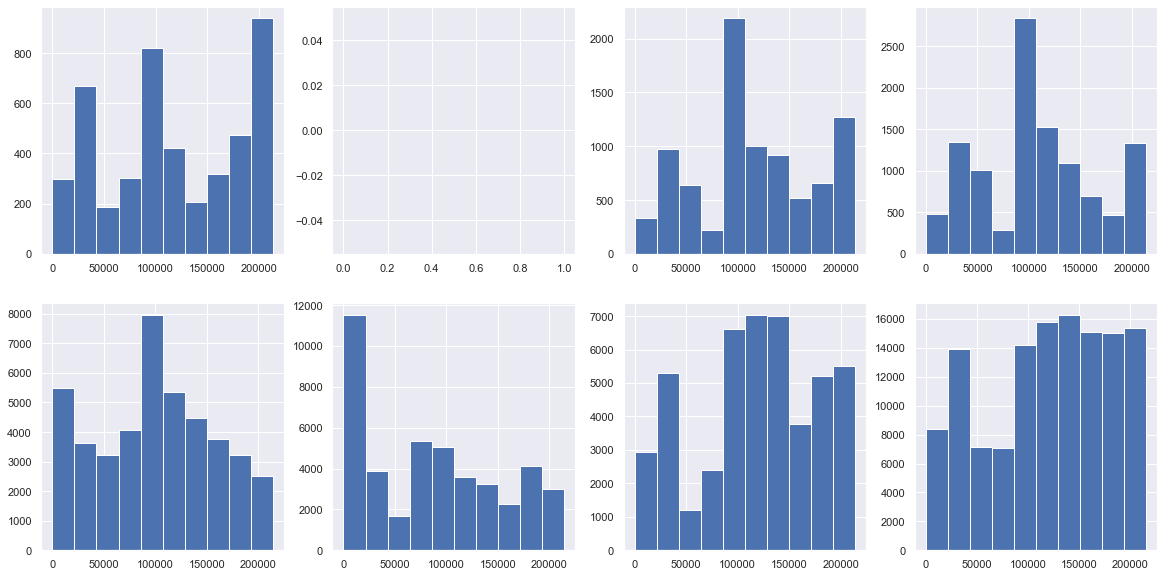

In [15]:
# see the distribution of the  NAs

fig,ax = plt.subplots(2,4,figsize = (20,10))
for j,i in enumerate(x_index):
    index = filter_tail.iloc[:,i].index[filter_tail.iloc[:,i].isna()]
    ax[j//4,j%4].hist(index)
#     ax[j//4,j%4].axvline(x = 50000, color = "r")
#     ax[j//4,j%4].axvline(x = 90000, color = "r")
    
# 50000-90000 less filtered
#after 90000, more filtered

# see the time point when more than 4 points were dropped

In [16]:
x = spine_all[1]
pts = np.delete(x,np.where(np.isnan(x))[0],axis=0)
less4 = []
for i in range(spine_all.shape[0]):
    length = len(np.delete(spine_all[i], np.where(np.isnan(spine_all[i]))[0],axis = 0))
    if length<4:
        less4.append(i)
    

(array([156., 416., 122., 116., 559., 263., 177., 200., 106., 582.]),
 array([5.200000e+01, 2.142330e+04, 4.279460e+04, 6.416590e+04,
        8.553720e+04, 1.069085e+05, 1.282798e+05, 1.496511e+05,
        1.710224e+05, 1.923937e+05, 2.137650e+05]),
 <a list of 10 Patch objects>)

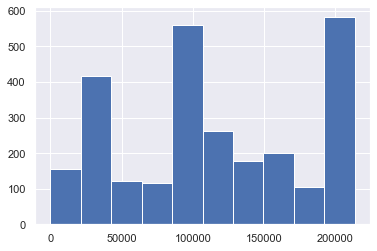

In [17]:
plt.hist(less4)

(array([36., 31., 14., 62., 16., 28., 20., 13., 10., 27.]),
 array([ 90000.,  91000.,  92000.,  93000.,  94000.,  95000.,  96000.,
         97000.,  98000.,  99000., 100000.]),
 <a list of 10 Patch objects>)

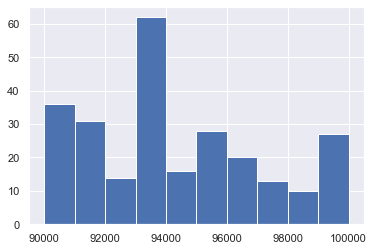

In [18]:
plt.hist(less4, range=[90000,100000])

(array([ 2., 11., 12., 11.,  9.,  4.,  0.,  0.,  0.,  0.]),
 array([93800., 93820., 93840., 93860., 93880., 93900., 93920., 93940.,
        93960., 93980., 94000.]),
 <a list of 10 Patch objects>)

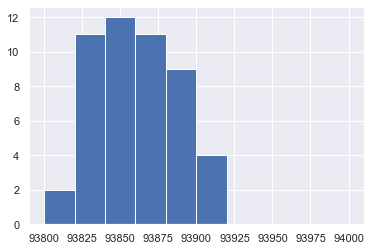

In [19]:
plt.hist(less4, range=[93800,94000])
## almost all filtered, extremely unstable period

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

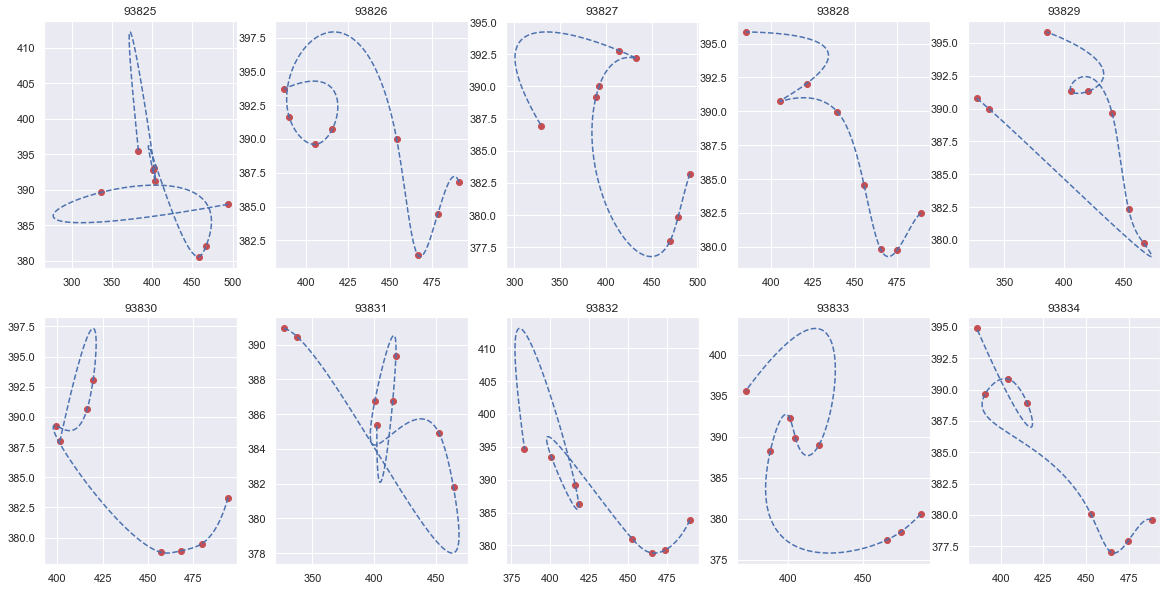

In [14]:
x = 93825
focus = range(x,x+10)
spine_10plot(spine_point(data_top2),focus)

In [24]:
#gap = data_top2.iloc[154871:154900,likelihood_index] # mismatch?  154871-gap?-154980

Above all, the NAs distribution is unstable, need to think about proper way to fill the data.

1. in this dataset, 93800-93900 are extremely unstable points(video)

# fill data for spine

In [15]:
# define fill fucntion
def fill_tail(data):
    # data = filter_tail.dropna(subset = (("A_head","x"),('F_spine1','x')))
    data = spine_point(data)
    remain_list = []
    # first find the longest non_na in the point
    for i in range(data.shape[0]):
        not_na = np.unique(np.where(~np.isnan(data[i]))[0])
        if (len(not_na)>=4):
            h = not_na[0]
            s1 = not_na[1]
            if (h == 0) & (s1==1):
                remain_list.append(i) ## filter  when do tail spine
                for j in range(len(not_na)):
                    if j > 1:
                        current = not_na[j]
                        pre = not_na[j-1]
                        point = current-pre
                        if point > 1:
                            dx = data[i][current][0]-data[i][pre][0]
                            dy = data[i][current][1]-data[i][pre][1]
                            for k in range(1, point):
                                data[i][pre+k][0] = data[i][pre][0]+k*dx/point
                                data[i][pre+k][1] = data[i][pre][1]+k*dy/point
    return(data[remain_list],remain_list)
        

In [16]:
fill_point, remain = fill_tail(filter_tail)
data_ori  = data_top2.iloc[remain,:]

## data used to build all feature

## plot and spine after fill

In [17]:
def spine_10plot2(data,remain, range_censor):
    j = 0
    fig,ax = plt.subplots(2,5,figsize=(20, 10))
    maintain = list()
    for i in range_censor:
        x = np.array(data[i])
        pts = np.delete(x,np.where(np.isnan(x))[0],axis=0)
        tck, u = interpolate.splprep(pts.T, u=None, s=0.0) 
        u_new = np.linspace(u.min(), u.max(), 1000)
        x_new, y_new = interpolate.splev(u_new, tck, der=0)
        ax[j//5,j%5].plot(pts[:,0], pts[:,1], 'ro')
        ax[j//5,j%5].plot(x_new, y_new, 'b--')
        ax[j//5,j%5].set_title(remain[i])
        maintain.append(len(pts))
        j = j+1
    return maintain


In [18]:
fill_point.shape

(209855, 8, 2)

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

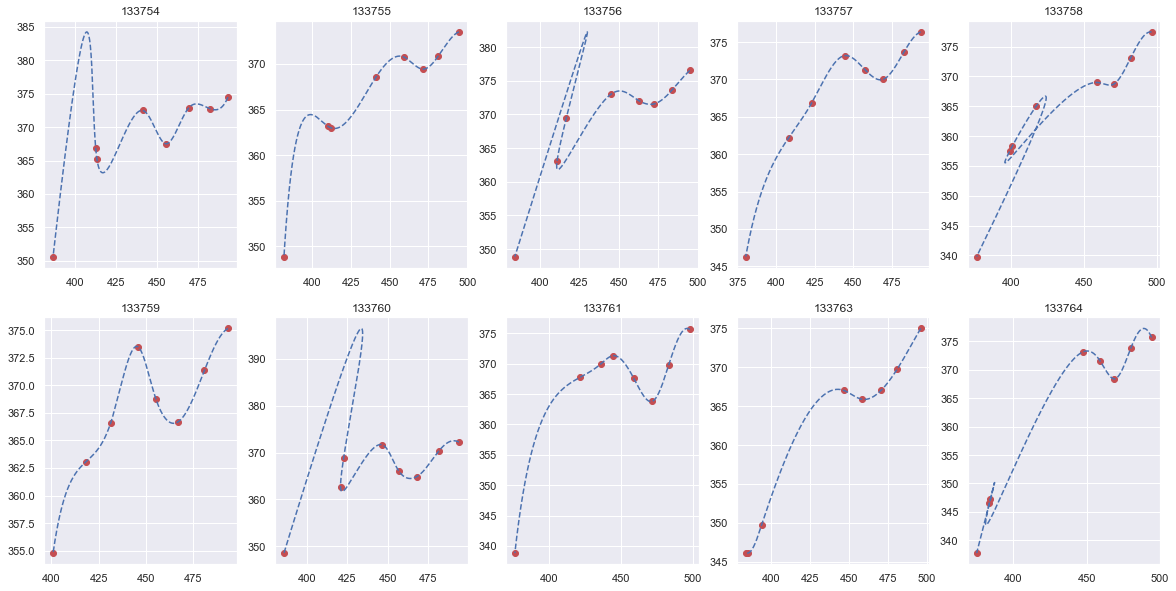

In [38]:
x = 130000
focus = range(x,x+10)
spine_10plot2(spine_point(data_ori),remain,focus)

[6, 6, 6, 4, 4, 4, 8, 4, 4, 8]

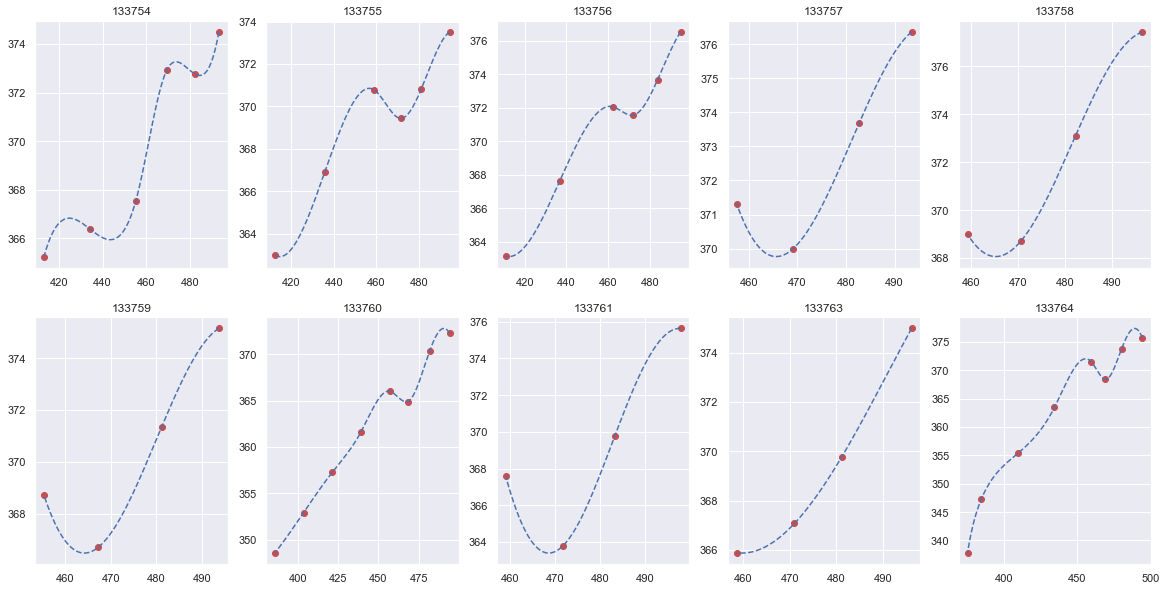

In [39]:
spine_10plot2(fill_point,remain,focus)

# rotation and tal beating 

In [31]:
def rotation(data_overall, fill_data):
    data = data_overall
    n = data.shape[0]
    ## transfer spline data to point vector
    spline_point = fill_data

    # origin and reference vector
    head = np.column_stack([data.iloc[:,0],data.iloc[:,1]]) # dim = 216059, 2
    spline1 = np.column_stack([data.iloc[:,15],data.iloc[:,16]])
        # dim = 216059, 2
    head_r = head-spline1

    ##  rotation matrix 
    norm = np.zeros(len(head_r))
    for i in range(len(head_r)):norm[i] =  (np.linalg.norm(head_r[i]))
    #norm = np.array(norm)
    angle = np.column_stack([head_r[:,0]/norm, head_r[:,1]/norm])
    angle2 = np.column_stack([-angle[:,1],angle[:,0]])
    rot_matrix = np.column_stack([angle,angle2])

     ## rotate point coordinates
    spline_rotate = np.zeros((n,8,2))
    for i in range(n):
        x = np.zeros((8,2))
        k = 0
        for j in spline_point[i].reshape((8,2), order = "F"):
            x[k] = np.dot(rot_matrix[i].reshape(2,2),j-spline1[i])
            k = k+1
        spline_rotate[i] = x
    return(spline_rotate)

 

In [32]:
rot_data = rotation(data_overall = data_ori, fill_data = fill_point)

[8, 8, 8, 8, 8, 8, 8, 8, 5, 8]

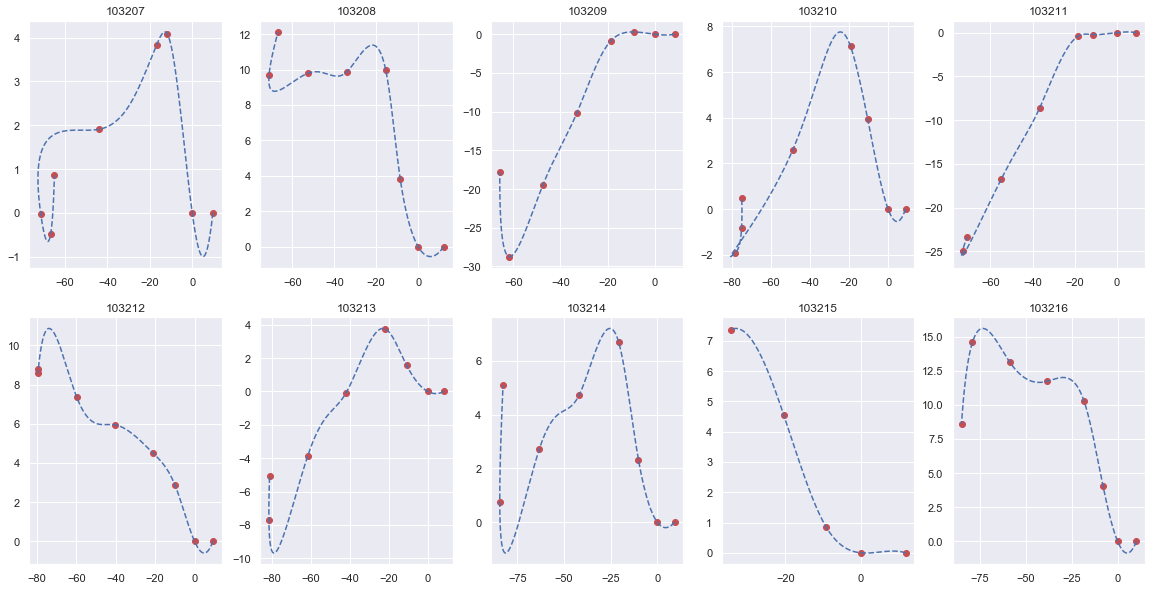

In [81]:
spine_10plot2(rot_data,remain, range(100300,100310))

# tail beating

In [34]:
def tail_spline(rotate_points):
    tail = np.zeros((rotate_points.shape[0],8))
    j=0
    for i in range(len(rotate_points)):
        pts = rotate_points[i]
        pts = np.delete(pts,np.where(np.isnan(pts))[0],axis=0)
        k = pts.shape[0]
        tck, u = interpolate.splprep(pts.T, u=None, s=0.0) 
        yder = interpolate.splev(u, tck, der=1)
        z = np.full(8, np.nan)
        z[0:k] = yder[1]/yder[0]
        tail[i] = np.array(z)
    return(tail)

# for i in range_censor:
#         x = np.array(data[i])
#         pts = np.delete(x,np.where(np.isnan(x))[0],axis=0)
#         tck, u = interpolate.splprep(pts.T, u=None, s=0.0) 
#         u_new = np.linspace(u.min(), u.max(), 1000)
#         x_new, y_new = interpolate.splev(u_new, tck, der=0)


In [35]:
tail = tail_spline(rot_data)

In [36]:
df = pd.DataFrame(tail)
na_col = []
for i in range(df.shape[1]):
    na_col.append(sum(df.iloc[:,i].isna()))
na_col
# last spine is too unstable

[0, 0, 0, 0, 2963, 9116, 39788, 123875]

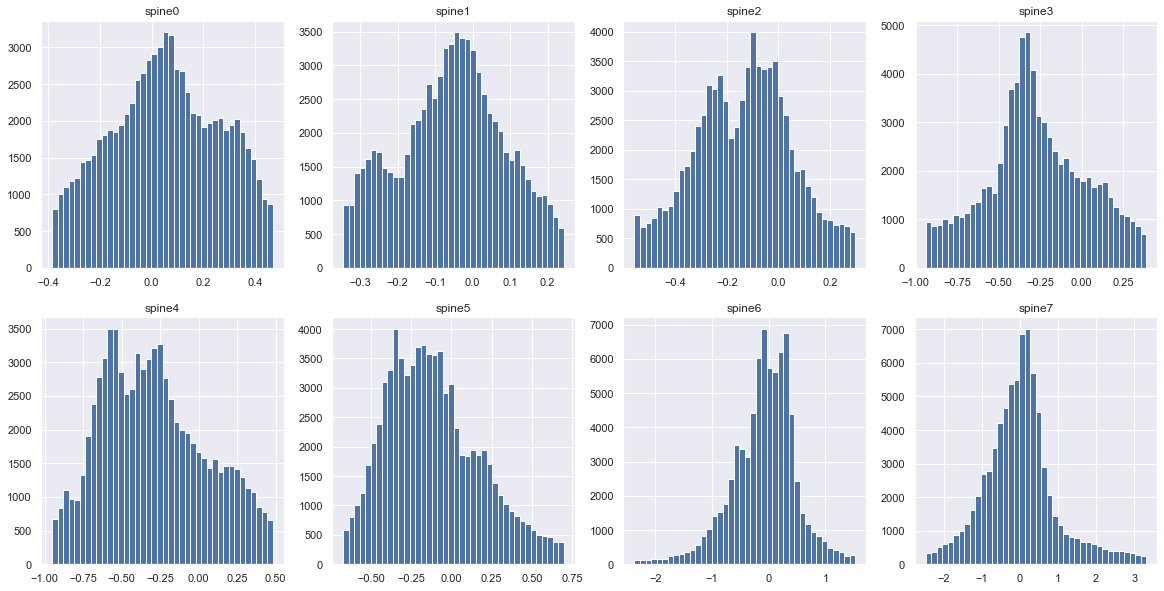

In [37]:
plot_tail(tail)

## tail angle from Yuyang

No rotation?

In [ ]:
def cal_angle(x,y):
    inner_product =x.dot(y)
    cos=inner_product/np.sqrt(np.sum(np.square(x)))/np.sqrt(np.sum(np.square(y)))
    angle=np.arccos(cos)/np.pi*180
    return angle

tail_angle=[]
for i in range(20000,50000):
    test_point=spine.iloc[i,:]
    y=test_point[[1,4,7,10,13,16,19,22,25]]
    x=test_point[[0,3,6,9,12,15,18,21,24]]
    pts=np.vstack([x,y]).T
    pts=pts[~np.isnan(pts).any(axis=1)]
    if(pts.shape[0]>=4):
        tck,u=interpolate.splprep(pts.T, u=None, s=0.0)
        dx,dy=interpolate.splev(u,tck,der=1)
        vec1=np.array([dy[0],dx[0]])
        vec2=np.array([dy[-1],dx[-1]])
        angle=cal_angle(vec1,vec2)
        tail_angle.append(angle)
    else:
        tail_angle.append(np.nan)

# using Moviepy to show the final outcome

In [ ]:
data1 = filter_tail.copy()
def focus(data,start):
    data1 = data.iloc[start:,]
    data1.index = range(len(data1))
    return data1

data2 = focus(data_top2,93800)

In [ ]:
import moviepy
from moviepy.editor import VideoFileClip, VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

#Focus_period = np.arange(8000, 9000)
Focus_data = data_top2
data2 = focus(data_top,93800)
data = data2 # define the data that you will be running through moviepy functions
duration = 5 
fps = 40
fig, ax = plt.subplots()

def make_frame(time):
    timeint = int(time*fps)
    ax.clear()
    x = data['A_head']['x'][timeint]
    y = data['A_head']['y'][timeint]
    ax.plot(x,y,'o')
    x = data['F_spine1']['x'][timeint]
    y = data['F_spine1']['y'][timeint]
    ax.plot(x,y,'o')
    x = data['G_spine2']['x'][timeint]
    y = data['G_spine2']['y'][timeint]
    ax.plot(x,y,'o')
    x = data['H_spine3']['x'][timeint]
    y = data['H_spine3']['y'][timeint]
    ax.plot(x,y,'o')
    x = data['I_spine4']['x'][timeint]
    y = data['I_spine4']['y'][timeint]
    ax.plot(x,y,'o')
    x = data['I_spine4']['x'][timeint]
    y = data['I_spine4']['y'][timeint]
    ax.plot(x,y,'o')
    x = data['J_spine5']['x'][timeint]
    y = data['J_spine5']['y'][timeint]
    ax.plot(x,y,'o')
    x = data['K_spine6']['x'][timeint]
    y = data['K_spine6']['y'][timeint]
    ax.plot(x,y,'o')
    x = data['L_spine7']['x'][timeint]
    y = data['L_spine7']['y'][timeint]
    ax.plot(x,y,'o')
    
    ax.set_ylim([0,500])
    ax.set_xlim([0,500])
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration = duration)
animation.write_videofile("points_93800_filter.mp4", fps=40)

#spine_point

In [ ]:
#%%

## Creates a list of pts arrays to prep for moviepy. 
## These functions will allow you to make a spline for any period of time
## for a dataframe. 
## you 
pts_all = []
x_all = []
y_all = []
def Combine_pts(data):
    for i in np.arange(len(data)):
        test_point = data.iloc[i,:]
        x = test_point[[0, 15, 18, 21, 24, 27, 30, 33]]
        y = test_point[[1, 16, 19, 22, 25, 28, 31, 34]]
        pts=np.vstack([x,y]).T
        pts=pts[~np.isnan(pts).any(axis=1)]
        pts_all.append(pts)
        print()
        if(pts.shape[0]>=4):
            tck,u=interpolate.splprep(pts.T, u=None, s=0.0)
            u_new = np.linspace(u.min(), u.max(), 100)
            x_new, y_new = interpolate.splev(u_new, tck, der=0)
            x_all.append(x_new)
            y_all.append(y_new)
    return( x_all, y_all)

x_all, y_all = Combine_pts(data1_49000)
duration = 20
fps = 40
fig, ax = plt.subplots()

def make_frame(time):
    timeint = int(time*fps)
    ax.clear()
    ax.plot(x_all[timeint], y_all[timeint], 'b--')
    ax.set_ylim([0,500])
    ax.set_xlim([0,500])
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration = duration)
animation.write_videofile("spline_49000.mp4", fps=40)

In [ ]:
#%%

## Creates a list of pts arrays to prep for moviepy. 
## These functions will allow you to make a spline for any period of time
## for a dataframe. 
## you 
pts_all = []
x_all = []
y_all = []
def Combine_pts(data):
    for i in np.arange(len(data)):
#         test_point = data.iloc[i,:]
#         x = test_point[[0, 15, 18, 21, 24, 27, 30, 33]]
#         y = test_point[[1, 16, 19, 22, 25, 28, 31, 34]]
#         pts=np.vstack([x,y]).T
        pts = data[i]
        pts=pts[~np.isnan(pts).any(axis=1)]
        pts_all.append(pts)
        print()
        if(pts.shape[0]>=4):
            tck,u=interpolate.splprep(pts.T, u=None, s=0.0)
            u_new = np.linspace(u.min(), u.max(), 100)
            x_new, y_new = interpolate.splev(u_new, tck, der=0)
            x_all.append(x_new)
            y_all.append(y_new)
    return( x_all, y_all)

x_all, y_all = Combine_pts(fill_data)
duration = 20
fps = 40
fig, ax = plt.subplots()

def make_frame(time):
    timeint = int(time*fps)
    ax.clear()
    ax.plot(x_all[timeint], y_all[timeint], 'b--')
    ax.set_ylim([0,500])
    ax.set_xlim([0,500])
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration = duration)
animation.write_videofile("spline_fill_49000.mp4", fps=40)

# 06/11


## using PCA and HMM for tail beating tangent

## PCA

In [38]:
tail_df = pd.DataFrame(tail).dropna()
tail_df.shape

(85980, 8)

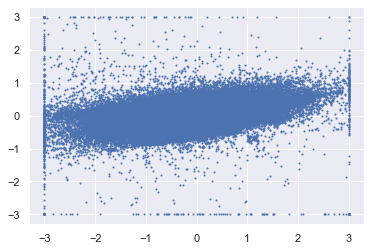

In [39]:
x=tail_df.values
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x)
pcs=pca.transform(x)
pcs=pcs[:,:2]
pcs = np.clip(pcs,-3,3)
plt.scatter(pcs[:,0],pcs[:,1],s = 1)

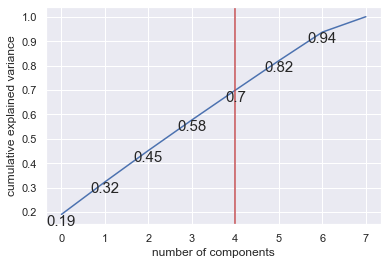

In [40]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
for a,b in zip(range(7),np.cumsum(pca.explained_variance_ratio_)):
    plt.text(a, b, round(b,2), ha='center', va='top', fontsize=15)
plt.axvline(x = 4,color = "r")
plt.show()

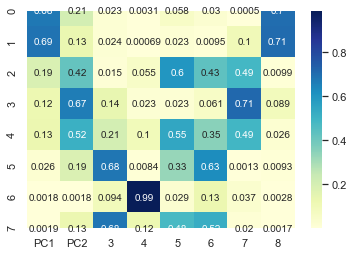

In [41]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2',"3","4","5","6","7","8"])
loadings_abs = abs(loadings)
import seaborn as sn
sn.heatmap(loadings_abs, annot=True,cmap = "YlGnBu")

# only use the first 2 pc to build HMM 

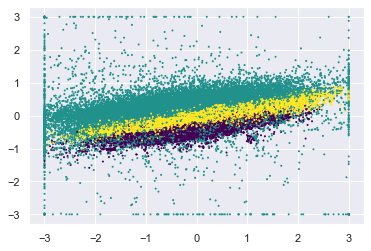

In [42]:
hmm_3=hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100)
hmm_3.fit(pcs)
y=hmm_3.predict(pcs)
plt.scatter(pcs[:, 0], pcs[:, 1], c=y,s=1, cmap='viridis')

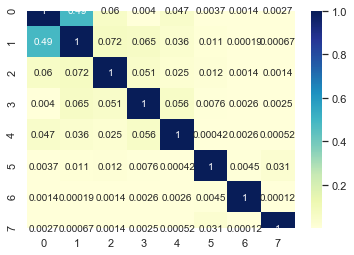

In [43]:
import seaborn as sn
corrMatrix = abs(tail_df.corr())
sn.heatmap(corrMatrix, annot=True,cmap = "YlGnBu")
plt.show()

# Add other feature and see PCA results together

In [44]:
from functions import *
filtered_df = data_ori # dataset without outlier of tail beating

operculum=auto_scoring_get_opdeg(filtered_df)
operculum=operculum.fillna(method="ffill")

ori=orientation(filtered_df)
ori=pd.Series(ori).fillna(method='ffill')

In [45]:
filtered_df.shape

(209855, 51)

In [46]:
feature  = pd.DataFrame(tail)
feature["operculum"] = operculum
feature["ori"] = ori

In [47]:
fill_feature = feature.fillna(method = "bfill").dropna()

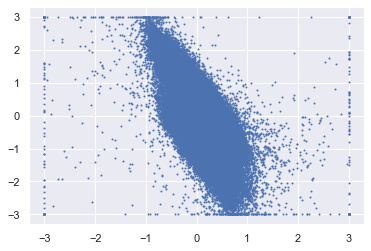

In [48]:
x=fill_feature.values
x = StandardScaler().fit_transform(x)
pca = PCA()
pca.fit(x)
pcs=pca.transform(x)
pcs=pcs[:,:2]
pcs = np.clip(pcs,-3,3)
plt.scatter(pcs[:,0],pcs[:,1],s = 1)

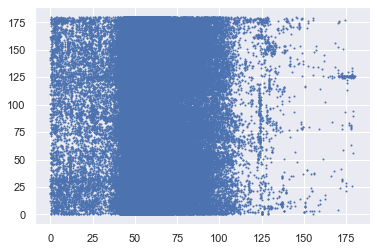

In [49]:
plt.scatter(fill_feature["operculum"], fill_feature["ori"],s = 1) 

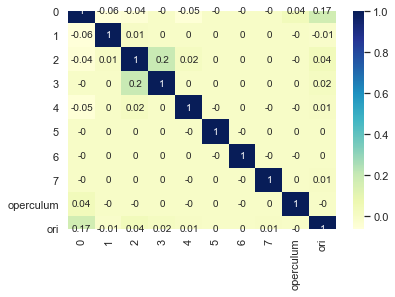

In [50]:
import seaborn as sn
corrMatrix = round(fill_feature.corr(),2)
sn.heatmap(corrMatrix, annot=True,cmap = "YlGnBu")
plt.show()

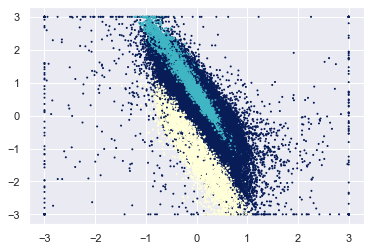

In [51]:
hmm_3=hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100)
hmm_3.fit(pcs)
y=hmm_3.predict(pcs)
plt.scatter(pcs[:, 0], pcs[:, 1], c=y,s=1, cmap='YlGnBu')

(array([8.4000e+01, 4.0000e+00, 5.0000e+00, 3.0000e+00, 7.0000e+00,
        7.0000e+00, 7.0000e+00, 1.0000e+01, 1.2000e+01, 1.6000e+01,
        8.0000e+00, 1.5000e+01, 1.8000e+01, 1.5000e+01, 4.3000e+01,
        7.0000e+01, 1.7200e+02, 4.4100e+02, 1.1810e+03, 2.8860e+03,
        9.9010e+03, 1.5296e+04, 2.1580e+04, 2.7254e+04, 3.0325e+04,
        2.7398e+04, 2.3762e+04, 1.9737e+04, 1.2994e+04, 7.8080e+03,
        4.3900e+03, 2.1330e+03, 1.1570e+03, 4.6900e+02, 1.9300e+02,
        9.0000e+01, 7.0000e+01, 4.5000e+01, 3.8000e+01, 2.6000e+01,
        1.9000e+01, 8.0000e+00, 1.9000e+01, 1.8000e+01, 8.0000e+00,
        1.2000e+01, 6.0000e+00, 3.0000e+00, 2.0000e+00, 8.7000e+01]),
 array([-3.  , -2.88, -2.76, -2.64, -2.52, -2.4 , -2.28, -2.16, -2.04,
        -1.92, -1.8 , -1.68, -1.56, -1.44, -1.32, -1.2 , -1.08, -0.96,
        -0.84, -0.72, -0.6 , -0.48, -0.36, -0.24, -0.12,  0.  ,  0.12,
         0.24,  0.36,  0.48,  0.6 ,  0.72,  0.84,  0.96,  1.08,  1.2 ,
         1.32,  1.44,  1.56,  1.68

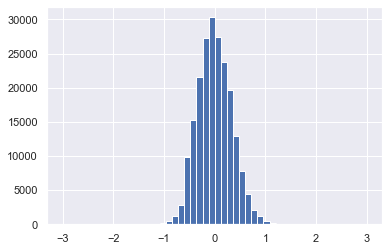

In [48]:
plt.hist(pcs[:,0],bins = 50)

# use first 4 pcs to build HMM

In [52]:
pcs=pca.transform(x)
pcs = pcs[:,:4]
pcs = np.clip(pcs,-3,3)

In [54]:
hmm_3=hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100)
hmm_3.fit(pcs)
y=hmm_3.predict(pcs)

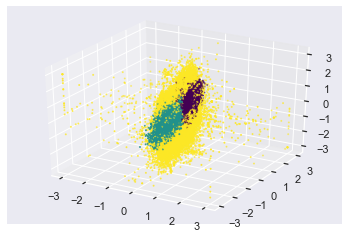

In [58]:
fig = plt.figure()
ax1 = plt.axes(projection='3d')
ax1.scatter3D(pcs[:, 0], pcs[:, 1],pcs[:, 2], s=1,c=y,cmap='viridis')

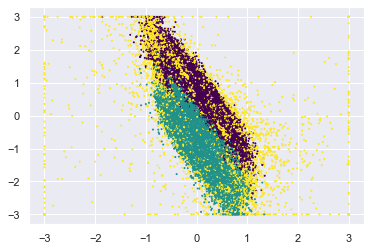

In [59]:
plt.scatter(pcs[:, 0], pcs[:, 1], c=y,s=1, cmap='viridis')

# see the distribution of y in PC

In [72]:
df = pd.DataFrame(pcs)
df.columns = ["PC1","PC2","PC3","PC4"]
df["y"] = y

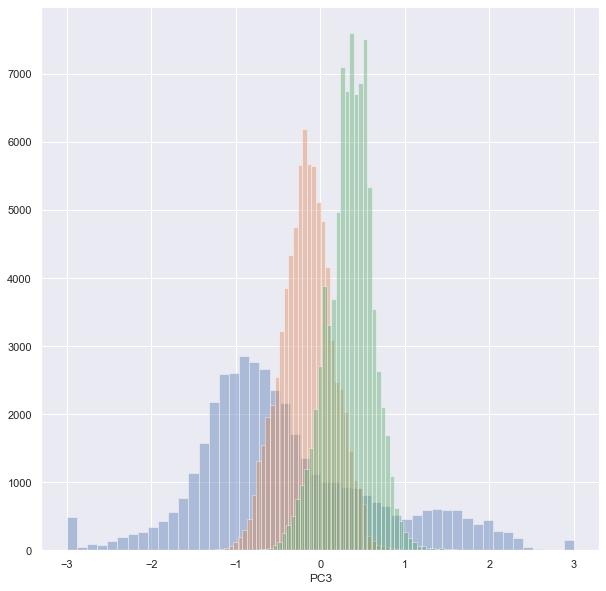

In [85]:
fig, ax = plt.subplots(figsize=(10, 10))
for group in df.y.unique():
    sn.distplot(df.loc[df.y == group, 'PC3'],
                 kde=False, ax=ax, label=group)